In [23]:
#General import
from sklearn import metrics
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import List, Tuple

#Qiskit import
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap, ZFeatureMap
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate
from qiskit.circuit.gate import Gate
algorithm_globals.random_seed = 13

#sklearn import
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles, make_moons, make_blobs
from sklearn.svm import SVC
from sklearn import datasets

In [24]:
class Individual():
    
    def __init__(
        self,
        numberOfGenes: int,
        numberOfFeatures: int,
        numberOfQubits: int,
        gates = [Gate]
    ) -> None:
    
        self._numberOfFeatures = numberOfFeatures
        self._numberOfGenes = numberOfGenes
        self._numberOfQubits = numberOfQubits
        self._genotype =  [[None, None, None, None] for _ in range(numberOfGenes)]
        self._gates = gates
        self._featurePositions = [[] for _ in range(numberOfFeatures)]
        
        
    def generateFirstIndividual(
        self
    ) -> None:
        
        featurePositions = []
        
        while len(featurePositions) < self._numberOfFeatures:
            position = random.randint(0, self._numberOfGenes-1)
            if position not in featurePositions:
                featurePositions.append(position)
    
        feature = 0
        for gene in featurePositions:
            qubit = random.randint(0, self._numberOfQubits-1)
            self._genotype[gene][0] = RZGate
            self._genotype[gene][1] = qubit
            self._genotype[gene][2] = None
            self._genotype[gene][3] = feature
            feature = feature + 1    
            
        for gene in [i for i in range(self._numberOfGenes) if i not in featurePositions]:
            
            gate = random.choice(self._gates)
            
            self._genotype[gene][0] = gate
            
            if gate == RZGate:
                
                qubit = random.randint(0, self._numberOfQubits-1)
                feature = random.randint(0, self._numberOfFeatures-1)
                self._genotype[gene][1] = qubit
                self._genotype[gene][2] = None
                self._genotype[gene][3] = feature
                
            elif gate == CXGate:
                
                control_qubit = random.randint(0, self._numberOfQubits-1)
                target_qubit = random.randint(0, self._numberOfQubits-1)
                while target_qubit == control_qubit:
                    target_qubit = random.randint(0, self._numberOfQubits-1)
                    
                self._genotype[gene][1] = target_qubit
                self._genotype[gene][2] = control_qubit
                self._genotype[gene][3] = None
                
            else:
                
                qubit = random.randint(0, self._numberOfQubits-1)
                self._genotype[gene][1] = qubit
                self._genotype[gene][2] = None
                self._genotype[gene][3] = None


    @property
    def numberOfFeatures(self) -> int:
        return self._numberOfFeatures
    
    @property
    def numberOfQubits(self) -> int:
        return self._numberOfQubits
    
    @property
    def numberOfGenes(self) -> int:
        return self._numberOfGenes
    
    @property
    def gates(self) -> List[Gate]:
        return self._gates
    
    @property 
    def genotype(self) -> List[Tuple[Gate, int, int, int]]:
        return self._genotype
    
    @genotype.setter 
    def genotype(self, new_genotype: List[Tuple[Gate, int, int, int]]):

        if len(new_genotype)!=self._numberOfGenes:
                raise ValueError('Wrong genotype lenght')
        
        self._genotype = new_genotype
        

    def getFenotype(
        self
    ) -> QuantumCircuit:
        
        trainingParams = ParameterVector('x', self._numberOfFeatures)
        
        fenotype = QuantumCircuit(self._numberOfQubits)
        
        for gene in range(self._numberOfGenes):
                
                gate = self._genotype[gene][0]

                if gate == RZGate:
                    fenotype.append(gate(trainingParams[self._genotype[gene][3]]), [self._genotype[gene][1]])
                    
                elif gate == CXGate:
                    fenotype.append(gate(), [self._genotype[gene][2], self._genotype[gene][1]])
                    
                else:
                    fenotype.append(gate(), [self._genotype[gene][1]])        

        return fenotype


    def getFeatureMask(
        self
    ) -> np.ndarray:
        
        feature_mask = np.zeros(self._numberOfFeatures, dtype=bool)

        for gene in range(self._numberOfGenes):
            
            if self._genotype[gene][0] == RZGate:
                feature_mask[self._genotype[gene][3]] = 1

        return feature_mask
        
    def mutate(
        self, 
        probability: float = 0.5
    ) -> None:
        
        if random.random() < probability: 
            
            gene = random.randint(0, self._numberOfGenes-1)
            
            self._genotype[gene] = [None, None, None, None]
            
            gate = random.choice(self._gates)
        
            self._genotype[gene][0] = gate

            if gate == RZGate:
                
                qubit = random.randint(0, self._numberOfQubits-1)
                feature = random.randint(0, self._numberOfFeatures-1)
                self._genotype[gene][1] = qubit
                self._genotype[gene][2] = None
                self._genotype[gene][3] = feature
                
            elif gate == CXGate:
                
                control_qubit = random.randint(0, self._numberOfQubits-1)
                target_qubit = random.randint(0, self._numberOfQubits-1)
                while target_qubit == control_qubit:
                    target_qubit = random.randint(0, self._numberOfQubits-1)
                    
                self._genotype[gene][1] = target_qubit
                self._genotype[gene][2] = control_qubit
                self._genotype[gene][3] = None
                
            else:
                
                qubit = random.randint(0, self._numberOfQubits-1)
                self._genotype[gene][1] = qubit
                self._genotype[gene][2] = None
                self._genotype[gene][3] = None



                
def crossover(
    parent1: Individual,
    parent2: Individual
    ) -> Tuple[Individual, Individual]:
        
        child1 = Individual(
            numberOfFeatures=parent1.numberOfFeatures, 
            numberOfGenes=parent1.numberOfGenes, 
            numberOfQubits=parent1.numberOfQubits, 
            gates=parent1.gates
        )
        child2 = Individual(
            numberOfFeatures=parent1.numberOfFeatures, 
            numberOfGenes=parent1.numberOfGenes, 
            numberOfQubits=parent1.numberOfQubits, 
            gates=parent1.gates
        )
        
        division_point = parent1.numberOfGenes // 2 #point where the circuit is cut

        



        

In [25]:
#Example 
gates = [XGate, SXGate, RZGate, CXGate]
first = Individual(numberOfFeatures=4, numberOfGenes=6, numberOfQubits=5, gates=gates)
first.generateFirstIndividual()
print(circuit_drawer(first.getFenotype()))
print(first.getFeatureMask())
first.mutate()
print(circuit_drawer(first.getFenotype()))
print(first.getFeatureMask())


        ┌────┐   ┌──────────┐            
q_0: ───┤ √X ├───┤ Rz(x[0]) ├────────────
     ┌──┴────┴──┐└──┬───┬───┘┌──────────┐
q_1: ┤ Rz(x[3]) ├───┤ X ├────┤ Rz(x[1]) ├
     └──────────┘   └─┬─┘    └──────────┘
q_2: ─────────────────┼──────────────────
                      │                  
q_3: ─────────────────■──────────────────
     ┌──────────┐                        
q_4: ┤ Rz(x[2]) ├────────────────────────
     └──────────┘                        
[ True  True  True  True]
        ┌────┐   ┌──────────┐            
q_0: ───┤ √X ├───┤ Rz(x[0]) ├────────────
     ┌──┴────┴──┐└──┬───┬───┘┌──────────┐
q_1: ┤ Rz(x[3]) ├───┤ X ├────┤ Rz(x[1]) ├
     └──────────┘   └─┬─┘    └──────────┘
q_2: ─────────────────┼──────────────────
                      │                  
q_3: ─────────────────■──────────────────
     ┌──────────┐                        
q_4: ┤ Rz(x[2]) ├────────────────────────
     └──────────┘                        
[ True  True  True  True]


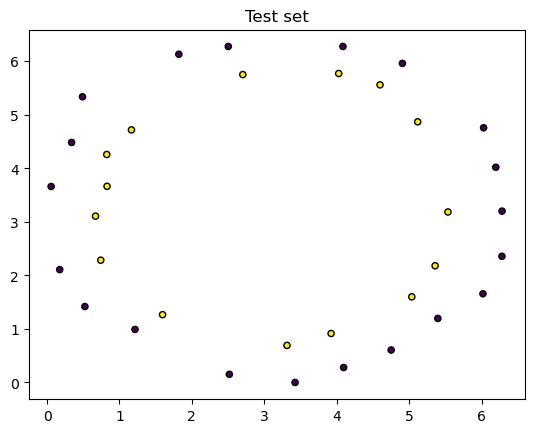

In [29]:
X, y = make_circles(n_samples=50, factor=0.8, noise=0.025, random_state=42)
#select which class and features to use
#class1 = 0
#class2 = 2
#feature1 = 0
#feature2 = 3
#
#iris = datasets.load_iris()
#
#X = iris.data[:, [feature1, feature2]]
#y = iris.target
#
#X = X[np.logical_or(y == class1, y == class2)]
#y = y[np.logical_or(y == class1, y == class2)]

X = MinMaxScaler(feature_range=(0, 2*np.pi)).fit_transform(X) #seems to have better results if compatible with the rotation encoding
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=13) 

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=20, edgecolor='k')
plt.title('Test set')
plt.show()

Generation number 0
Best fitness: 0.3333333333333333
     ┌──────────┐┌────┐┌──────────┐┌──────────┐
q_0: ┤ Rz(x[1]) ├┤ √X ├┤ Rz(x[1]) ├┤ Rz(x[0]) ├
     └──────────┘└────┘└──────────┘└──────────┘
q_1: ──────────────────────────────────────────
                                               


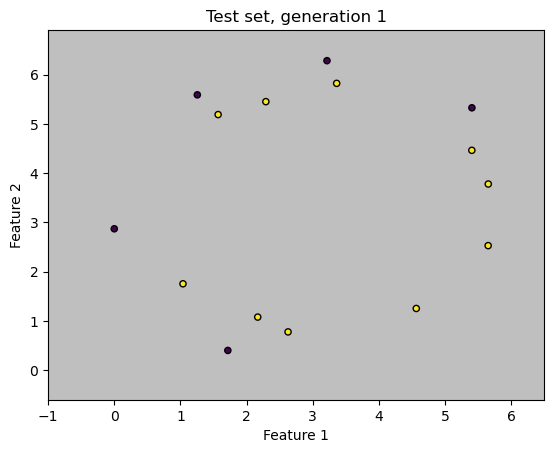

-----------------------------------------
Generation number 1
Best fitness: 0.4
Best feature map:
     ┌──────────┐┌────┐┌──────────┐
q_0: ┤ Rz(x[1]) ├┤ √X ├┤ Rz(x[1]) ├
     └──┬───┬───┘└────┘└──────────┘
q_1: ───┤ X ├──────────────────────
        └───┘                      
Generation number 2
Best fitness: 0.4
Best feature map:
     ┌──────────┐┌────┐┌──────────┐
q_0: ┤ Rz(x[1]) ├┤ √X ├┤ Rz(x[1]) ├
     └──┬───┬───┘└────┘└──────────┘
q_1: ───┤ X ├──────────────────────
        └───┘                      


In [30]:
maximumGenerations = 3
targetFitness = 0.95
numberOfGenes = 4
numberOfQubits = 2
gates = [XGate, SXGate, RZGate, CXGate]
k = 3

numberOfGenerations = 0

#Generate the first individual
bestIndividual = Individual(numberOfFeatures = X_train.shape[1], numberOfGenes = numberOfGenes, numberOfQubits = X_train.shape[1], gates = gates)
bestIndividual.generateFirstIndividual()
feature_map = bestIndividual.getFenotype()
feature_mask = bestIndividual.getFeatureMask()
kernel = FidelityQuantumKernel(feature_map=feature_map)
svc = SVC(kernel=kernel.evaluate)
svc.fit(X_train[:, feature_mask], y_train)
bestFitness = svc.score(X_test[:, feature_mask], y_test)
bestSVC = svc

print(f'Generation number {numberOfGenerations}')
numberOfGenerations = numberOfGenerations + 1
print(f'Best fitness: {bestFitness}')
print(circuit_drawer(bestIndividual.getFenotype()))

feature_mask = bestIndividual.getFeatureMask()
#Print decision boundary for the first generation
if np.all(feature_mask) and bestIndividual.numberOfFeatures==2: #print onyl if we have two features and both features survived
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
    Z = bestSVC.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap='binary')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
    plt.xlabel(f'Feature 1')
    plt.ylabel(f'Feature 2')
    plt.title(f'Test set, generation {numberOfGenerations}')
    plt.show()
print('-----------------------------------------')

while bestFitness < targetFitness and numberOfGenerations < maximumGenerations: 
    
    currentGeneration = []
    
    #Generate k copies
    for i in range(k):
        currentGeneration.append(None)
        currentGeneration[i] = deepcopy(bestIndividual)

    #Mutates the k copies and evaluate the fitness
    for i in range(k):
        currentGeneration[i].mutate()
        feature_map = currentGeneration[i].getFenotype()
        feature_mask = currentGeneration[i].getFeatureMask()
        kernel = FidelityQuantumKernel(feature_map=feature_map)
        svc = SVC(kernel=kernel.evaluate)
        svc.fit(X_train[:, feature_mask], y_train)
        fitness = svc.score(X_test[:, feature_mask], y_test)
        
        if fitness > bestFitness:
            bestIndividual = deepcopy(currentGeneration[i])
            bestFitness = fitness
            bestSVC = svc
    
    #Print best circuit of the generation
    print(f'Generation number {numberOfGenerations}')
    numberOfGenerations = numberOfGenerations + 1
    print(f'Best fitness: {bestFitness}')
    print('Best feature map:')
    print(circuit_drawer(bestIndividual.getFenotype()))

    #Print decision boundary
    feature_mask = bestIndividual.getFeatureMask()
    if np.all(feature_mask) and bestIndividual.numberOfFeatures==2: #print onyl if we have two features and both features survived
        x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
        y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max, 0.5))
        Z = bestSVC.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap='binary')
        plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=20, edgecolor='k')
        plt.xlabel(f'Feature 1')
        plt.ylabel(f'Feature 2')
        plt.title(f'Test set, generation {numberOfGenerations}')
        plt.show()
        print('-----------------------------------------')
    
        